In [39]:
import os
import json
import cv2
from PIL import Image, ImageFilter, ImageEnhance
from shapely.geometry import Polygon


In [40]:
# Define the paths to the directories containing the output and ground truth files
output_files_dir = 'out_txt_dir/'
ground_truth_files_dir = 'ann/'

# Function to calculate IoU
def calculate_iou(box1, box2):
    poly1 = Polygon([(box1[0], box1[1]), (box1[2], box1[1]), (box1[2], box1[3]), (box1[0], box1[3])])
    poly2 = Polygon([(box2[0], box2[1]), (box2[2], box2[1]), (box2[2], box2[3]), (box2[0], box2[3])])
    iou = poly1.intersection(poly2).area / poly1.union(poly2).area
    return iou

# Initialize metrics
true_positives, false_positives, false_negatives = 0, 0, 0
ious = []

# Iterate over all output files
for filename in os.listdir(output_files_dir):
    if filename.endswith('.txt'):
        # Construct paths to the output and corresponding ground truth file
        output_file_path = os.path.join(output_files_dir, filename)
        ground_truth_file_path = os.path.join(ground_truth_files_dir, filename.replace('.txt', '.json'))

        # Skip if ground truth file does not exist
        if not os.path.exists(ground_truth_file_path):
            continue

        # Load ground truth data
        with open(ground_truth_file_path, 'r') as gt_file:
            ground_truth_data = json.load(gt_file)

        # Convert ground truth polygons to bounding boxes
        ground_truth_boxes = []
        for obj in ground_truth_data['objects']:
            points = obj['points']['exterior']
            xs, ys = zip(*points)
            x_min, x_max = min(xs), max(xs)
            y_min, y_max = min(ys), max(ys)
            ground_truth_boxes.append((x_min, y_min, x_max, y_max))

        # Load output bounding boxes
        output_boxes = []
        with open(output_file_path, 'r') as out_file:
            for line in out_file:
                x1, y1, x2, y2, x3, y3, x4, y4, _ = map(int, line.split(','))
                x_min, x_max = min(x1, x2, x3, x4), max(x1, x2, x3, x4)
                y_min, y_max = min(y1, y2, y3, y4), max(y1, y2, y3, y4)
                output_boxes.append((x_min, y_min, x_max, y_max))

        # Calculate metrics for each file
        iou_threshold = 0.5
        file_true_positives, file_false_positives, file_false_negatives = 0, 0, 0

        for gt_box in ground_truth_boxes:
            matched = False
            for out_box in output_boxes:
                iou = calculate_iou(gt_box, out_box)
                if iou >= iou_threshold:
                    file_true_positives += 1
                    ious.append(iou)
                    matched = True
                    break
            if not matched:
                file_false_negatives += 1

        file_false_positives = len(output_boxes) - file_true_positives

        true_positives += file_true_positives
        false_positives += file_false_positives
        false_negatives += file_false_negatives

# Calculate overall metrics
precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
average_iou = sum(ious) / len(ious) if ious else 0

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")
print(f"Average IoU: {average_iou}")


Precision: 0.72083197920052
Recall: 0.35733848880296437
F1 Score: 0.4778112882378284
Average IoU: 0.7821017796934308


Preprocessing: Cropping Bounding Boxes

In [41]:
def find_image_path(base_folder, base_filename, extensions):
    for ext in extensions:
        image_path = os.path.join(base_folder, f"{base_filename}.{ext}")
        if os.path.exists(image_path):
            return image_path, ext
    return None, None

def crop_bounding_boxes(image_folder, annotations_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    extensions = ['jpg', 'jpeg', 'png']

    for filename in os.listdir(annotations_folder):
        if filename.endswith(".txt"):
            txt_path = os.path.join(annotations_folder, filename)
            with open(txt_path, 'r') as file:
                lines = file.readlines()

                base_filename = os.path.splitext(filename)[0]
                image_path, image_ext = find_image_path(image_folder, base_filename, extensions)

                if image_path:
                    image = cv2.imread(image_path)
                    if image is None or not image.size:
                        print(f"Failed to load image: {image_path}")
                        continue

                    image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

                    for i, line in enumerate(lines):
                        coords = [int(x) for x in line.split(',')[:-1]]  # Exclude the label
                        x_coords = coords[0::2]
                        y_coords = coords[1::2]
                        x_min, x_max = min(x_coords), max(x_coords)
                        y_min, y_max = min(y_coords), max(y_coords)

                        if 0 <= x_min < x_max <= image.width and 0 <= y_min < y_max <= image.height:
                            cropped_image = image.crop((x_min, y_min, x_max, y_max))
                            output_filename = f"{base_filename}_{i}.{image_ext}"
                            output_path = os.path.join(output_folder, output_filename)
                            cropped_image.save(output_path)
                        else:
                            print(f"Invalid cropping coordinates for file: {filename}")
                else:
                    print(f"No matching image file found for JSON file: {filename}")

image_folder = "out_vis_dir/"
annotations_folder = "out_txt_dir/"
output_folder = "cropped/"
crop_bounding_boxes(image_folder, annotations_folder, output_folder)


Invalid cropping coordinates for file: 00839.txt
Invalid cropping coordinates for file: 00810.txt
Invalid cropping coordinates for file: 00623.txt
Invalid cropping coordinates for file: 00623.txt
Invalid cropping coordinates for file: 00145.txt
Invalid cropping coordinates for file: 00145.txt
Invalid cropping coordinates for file: 00621.txt
No matching image file found for JSON file: 00812.txt
Invalid cropping coordinates for file: 00806.txt
Invalid cropping coordinates for file: 00379.txt
Invalid cropping coordinates for file: 00386.txt
Invalid cropping coordinates for file: 00386.txt
Invalid cropping coordinates for file: 00393.txt
Invalid cropping coordinates for file: 00393.txt
Invalid cropping coordinates for file: 00393.txt
Invalid cropping coordinates for file: 00393.txt
Invalid cropping coordinates for file: 00436.txt
Invalid cropping coordinates for file: 00191.txt
Invalid cropping coordinates for file: 00191.txt
Invalid cropping coordinates for file: 00191.txt
Invalid croppin

KeyboardInterrupt: 

Preprocessing: Greyscaling, Enhancing Contrast, Binarization, Noise Removal

In [ ]:
# Define the paths
cropped_images_folder = 'cropped/'
new_prep_folder = 'Preprocessed/'

# Create the new_prep folder if it doesn't exist
if not os.path.exists(new_prep_folder):
    os.makedirs(new_prep_folder)

# Function for preprocessing
def preprocess_image_for_ocr(image):
    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Mild contrast enhancement
    alpha = 1.3  # Contrast control (1.0-3.0)
    beta = 0     # Brightness control (0-100)
    adjusted_contrast = cv2.convertScaleAbs(gray_image, alpha=alpha, beta=beta)

    # Binarization
    _, binary_img = cv2.threshold(adjusted_contrast, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Noise removal
    denoised_img = cv2.medianBlur(binary_img, 3)

    return denoised_img

# Process each cropped image
for filename in os.listdir(cropped_images_folder):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(cropped_images_folder, filename)
        image = cv2.imread(image_path)

        # Preprocess the image
        preprocessed_image = preprocess_image_for_ocr(image)

        # Save the preprocessed image
        preprocessed_image_path = os.path.join(new_prep_folder, filename)
        cv2.imwrite(preprocessed_image_path, preprocessed_image)


Use OCR on preprocessed images

In [ ]:
# Add more data to training data

# Function to extract Arabic values from JSON data
def extract_arabic_from_json(json_data):
    arabic_values = []
    for obj in json_data["objects"]:
        for tag in obj.get("tags", []):
            if tag.get("name") == "Transcription":
                arabic_values.append(tag.get("value"))
    return arabic_values

# Function to write Arabic values to a text file
def write_to_file(arabic_values, file_path):
    with open(file_path, "a", encoding="utf-8") as file:  # 'a' mode for appending
        for value in arabic_values:
            file.write(value + "\n")

# Function to process all JSON files in a folder
def process_folder(folder_path, output_file_path):
    for filename in os.listdir(folder_path):
        if filename.endswith(".json"):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r', encoding='utf-8') as file:
                json_data = json.load(file)
                arabic_values = extract_arabic_from_json(json_data)
                write_to_file(arabic_values, output_file_path)

# Folder containing JSON files and Output file path
json_folder_path = "ann/"  # Change to your folder path
output_file_path = "arabic_text_combined.txt"  # Output file path

# Process the folder
process_folder(json_folder_path, output_file_path)

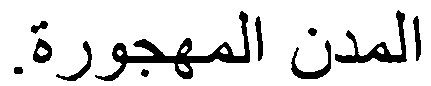

المد . لمهجور "0



In [ ]:
# Test Tesseract Arabic OCR

'''
brew install tesseract
brew install tesseract-lang  # This will install language support including Arabic
pip install pytesseract
'''
import os
import pytesseract
pytesseract.pytesseract.tesseract_cmd = '/opt/homebrew/bin/tesseract'  # use the path found from your terminal

# Trained model
# os.environ["TESSDATA_PREFIX"] = "/Users/z11241/Desktop/out_results/tesseract_tutorial/tesstrain/data"
# os.environ["TESSDATA_PREFIX"] = "/Users/z11241/anaconda3/envs/NLP/share/tessdata/"
#Base model 
os.environ["TESSDATA_PREFIX"] = "/Users/z11241/Desktop/out_results/tesseract_tutorial/tesseract/tessdata"



# test a single image

# Load an image from file
image_path = 'Preprocessed/00514_13.jpg'
image = Image.open(image_path)

# Use Tesseract to do OCR on the image
text = pytesseract.image_to_string(image, lang='ara')
from IPython.display import display

# Display the image
display(image)

# Print the extracted text
print(text)

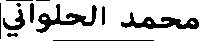

محماد الحلوائنقٍاْ



In [105]:
# Test Tesseract Arabic OCR

'''
brew install tesseract
brew install tesseract-lang  # This will install language support including Arabic
pip install pytesseract
'''
import os
import pytesseract
pytesseract.pytesseract.tesseract_cmd = '/opt/homebrew/bin/tesseract'  # use the path found from your terminal

# Trained model
os.environ["TESSDATA_PREFIX"] = "/Users/z11241/Desktop/out_results/tesseract_tutorial/tesstrain/data"
# os.environ["TESSDATA_PREFIX"] = "/Users/z11241/anaconda3/envs/NLP/share/tessdata/"
#Base model 
# os.environ["TESSDATA_PREFIX"] = "/Users/z11241/Desktop/out_results/tesseract_tutorial/tesseract/tessdata"



# test a single image

# Load an image from file
image_path = 'Preprocessed/00711_3.jpg'
image = Image.open(image_path)

# Use Tesseract to do OCR on the image
text = pytesseract.image_to_string(image, lang='ara2')
from IPython.display import display

# Display the image
display(image)

# Print the extracted text
print(text)

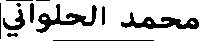

محمد الحلواني )



In [104]:
# Test Tesseract Arabic OCR

'''
brew install tesseract
brew install tesseract-lang  # This will install language support including Arabic
pip install pytesseract
'''
import os
import pytesseract
pytesseract.pytesseract.tesseract_cmd = '/opt/homebrew/bin/tesseract'  # use the path found from your terminal

# Trained model
os.environ["TESSDATA_PREFIX"] = "/Users/z11241/Desktop/out_results/tesseract_tutorial/tesstrain/data"
# os.environ["TESSDATA_PREFIX"] = "/Users/z11241/anaconda3/envs/NLP/share/tessdata/"
#Base model 
# os.environ["TESSDATA_PREFIX"] = "/Users/z11241/Desktop/out_results/tesseract_tutorial/tesseract/tessdata"



# test a single image

# Load an image from file
image_path = 'Preprocessed/00711_3.jpg'
image = Image.open(image_path)

# Use Tesseract to do OCR on the image
text = pytesseract.image_to_string(image, lang='ara3')
from IPython.display import display

# Display the image
display(image)

# Print the extracted text
print(text)

In [107]:
# output gt text from json file

def extract_ground_truth_from_directory(json_dir, output_dir):
    # Create the output directory 'gt' if it doesn't exist
    output_dir = os.path.join(json_dir, output_dir)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Process each JSON file in the directory
    for filename in os.listdir(json_dir):
        if filename.lower().endswith('.json'):
            json_file_path = os.path.join(json_dir, filename)
            process_json_file(json_file_path, filename, output_dir)

def process_json_file(json_file_path, json_filename, output_dir):
    with open(json_file_path, 'r') as file:
        data = json.load(file)

    base_filename = os.path.splitext(json_filename)[0]
    counter = 0

    # Process each object in the JSON data
    for obj in data['objects']:
        if 'tags' in obj:
            for tag in obj['tags']:
                if tag['name'] == 'Transcription':
                    ground_truth_text = tag['value']
                    output_filename = f"{base_filename}_{counter}.txt"
                    counter += 1

                    with open(os.path.join(output_dir, output_filename), 'w', encoding='utf-8') as text_file:
                        text_file.write(ground_truth_text)

json_directory = 'ann/'
extract_ground_truth_from_directory(json_directory, 'gt')


In [110]:
# Perform Tesseract OCR on dataset

# Trained model
os.environ["TESSDATA_PREFIX"] = "/Users/z11241/Desktop/out_results/tesseract_tutorial/tesstrain/data"

def perform_ocr_on_directory(image_dir, output_dir):
    # Ensure the output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Loop through all files in the image directory
    for filename in os.listdir(image_dir):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
            try:
                # Load the image
                image_path = os.path.join(image_dir, filename)
                image = Image.open(image_path)

                # Perform OCR using Tesseract
                text = pytesseract.image_to_string(image, lang='ara3')

                # Save the extracted text to a file
                output_file_path = os.path.join(output_dir, os.path.splitext(filename)[0] + '.txt')
                with open(output_file_path, 'w', encoding='utf-8') as file:
                    file.write(text)

            except Exception as e:
                print(f"Error processing {filename}: {e}")

image_directory = 'Preprocessed/'
output_directory = 'OCR_out/'
perform_ocr_on_directory(image_directory, output_directory)

Evaluate OCR Results